In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/Likenot_ML/bratabase_cup.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/Likenot_ML/bratabase_cup')

In [ ]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/Likenot_ML/bratabase_cup_gradient.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/Likenot_ML/bratabase_cup_gradient')

데이터 불러오기

: train - 0.8 / val - 0.1 / test - 0.1

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Likenot_ML/bratabase_cup/train',
    class_mode='categorical',
    target_size=(160, 160),
    batch_size=100
)

train_augmentation = ImageDataGenerator(rescale=1/255,
                                        rotation_range=20,
                                        height_shift_range=0.1,
                                        shear_range=0.2,
                                        horizontal_flip=True,
                                        fill_mode='nearest')

train_generator_aug = train_augmentation.flow_from_directory(
    '/content/drive/MyDrive/Likenot_ML/bratabase_cup/train',
    class_mode='categorical',
    target_size=(160, 160),
    batch_size=100
)

validation_datagen = ImageDataGenerator(rescale=1/255)

validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/Likenot_ML/bratabase_cup/val',
    class_mode='categorical',
    target_size=(160, 160),
    batch_size=100
)

test_datagen = ImageDataGenerator(rescale=1/255)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Likenot_ML/bratabase_cup/test',
    class_mode='categorical',
    target_size=(160, 160),
    batch_size=100
)

Found 1800 images belonging to 3 classes.
Found 1800 images belonging to 3 classes.
Found 450 images belonging to 3 classes.
Found 249 images belonging to 3 classes.


# Pre-trained MobileNet ( augmentation X )

1. (1) MobileNet conv layer 고정 모델 형성

In [ ]:
from keras.applications.mobilenet import MobileNet
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import RMSprop

base_model = MobileNet(include_top=False, 
                       input_shape=train_generator.image_shape,
                       weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


base_learning_rate = 0.0001
model.compile(optimizer=RMSprop(lr=base_learning_rate), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 80, 80, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 80, 80, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 80, 80, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 80, 80, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 80, 80, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 80, 80, 32)        0   

1. (2) 학습 전 모델 성능 확인 ( validation data로 evaluate 진행 )

In [ ]:
validation_steps = 20
loss0, accuracy0 = model.evaluate(validation_generator, steps=validation_steps)
print('initial loss: {0:.4f}\ninitial accuracy: {1:.4f}'.format(loss0, accuracy0))

20/20 [==============================] - 2s 34ms/step - loss: 1.0052 - accuracy: 0.4868
initial loss: 1.0064
initial accuracy: 0.4867


1. (3) 모델 학습 

In [ ]:
initial_epochs = 50
history = model.fit(train_generator, 
                    validation_data=validation_generator, 
                    epochs=initial_epochs)

Epoch 1/50
18/18 [==============================] - 6s 259ms/step - loss: 0.9403 - accuracy: 0.5561 - val_loss: 0.8008 - val_accuracy: 0.5978
Epoch 2/50
18/18 [==============================] - 4s 247ms/step - loss: 0.6931 - accuracy: 0.6722 - val_loss: 0.7822 - val_accuracy: 0.6311
Epoch 3/50
18/18 [==============================] - 4s 248ms/step - loss: 0.6612 - accuracy: 0.6894 - val_loss: 0.7591 - val_accuracy: 0.6378
Epoch 4/50
18/18 [==============================] - 4s 243ms/step - loss: 0.5860 - accuracy: 0.7156 - val_loss: 0.9720 - val_accuracy: 0.5867
Epoch 5/50
18/18 [==============================] - 4s 243ms/step - loss: 0.5538 - accuracy: 0.7456 - val_loss: 0.7327 - val_accuracy: 0.6556
Epoch 6/50
18/18 [==============================] - 4s 244ms/step - loss: 0.5180 - accuracy: 0.7739 - val_loss: 0.7723 - val_accuracy: 0.6600
Epoch 7/50
18/18 [==============================] - 4s 246ms/step - loss: 0.4912 - accuracy: 0.7867 - val_loss: 0.7637 - val_accuracy: 0.6667
Epoch 

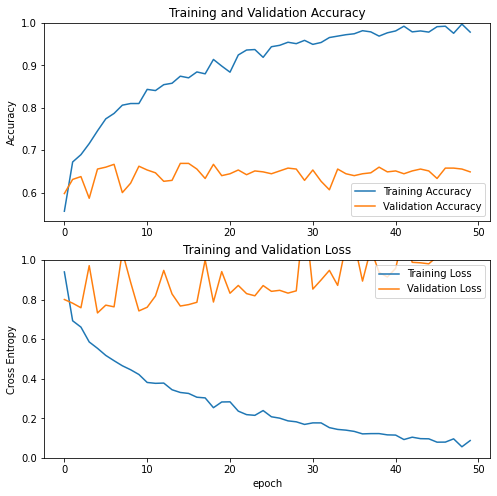

In [ ]:
# 학습 시각화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

1. (4) 학습 후 모델 성능 확인 ( test data로 evaluate 진행 )

In [ ]:
test_steps = 20
pre_trained_loss, pre_trained_acc = model.evaluate(test_generator, steps=test_steps)
print('학습 후 loss: {0:.4f}\n학습 후 accuracy: {1:.4f}'.format(pre_trained_loss, pre_trained_acc))

20/20 [==============================] - 1s 26ms/step - loss: 0.6961 - accuracy: 0.6867
학습 후 loss: 0.6961
학습 후 accuracy: 0.6867


2. (1) MobileNet fine tuning 모델 형성 : 최상위 층 고정 해제

In [ ]:
# base model의 모든 층 고정 해제
base_model.trainable = True

# base model의 층 개수 확인
print('Number of layers in the base model:', len(base_model.layers))

# 'fine_tune_at' 이전의 층 모두 고정
fine_tune_at = 70
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model: 86


In [ ]:
# 더 낮은 학습 비율로 기존의 model compile 진행

model.compile(optimizer=RMSprop(lr=base_learning_rate/10), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 80, 80, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 80, 80, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 80, 80, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 80, 80, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 80, 80, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 80, 80, 32)        0   

2. (2) 훈련된 기존 모델에 추가로 훈련 진행

In [ ]:
fine_tune_epochs = 30
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_generator,
                         validation_data=validation_generator,
                         initial_epoch=history.epoch[-1],
                         epochs=total_epochs)

Epoch 50/80
18/18 [==============================] - 7s 284ms/step - loss: 0.2434 - accuracy: 0.9041 - val_loss: 1.1596 - val_accuracy: 0.6111
Epoch 51/80
18/18 [==============================] - 4s 243ms/step - loss: 0.2397 - accuracy: 0.9015 - val_loss: 1.1337 - val_accuracy: 0.6267
Epoch 52/80
18/18 [==============================] - 4s 248ms/step - loss: 0.1730 - accuracy: 0.9495 - val_loss: 1.1625 - val_accuracy: 0.6156
Epoch 53/80
18/18 [==============================] - 4s 247ms/step - loss: 0.1453 - accuracy: 0.9558 - val_loss: 1.1052 - val_accuracy: 0.6511
Epoch 54/80
18/18 [==============================] - 4s 250ms/step - loss: 0.1408 - accuracy: 0.9659 - val_loss: 1.1343 - val_accuracy: 0.6356
Epoch 55/80
18/18 [==============================] - 4s 247ms/step - loss: 0.1071 - accuracy: 0.9815 - val_loss: 1.1135 - val_accuracy: 0.6600
Epoch 56/80
18/18 [==============================] - 4s 248ms/step - loss: 0.0888 - accuracy: 0.9904 - val_loss: 1.1201 - val_accuracy: 0.6689

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

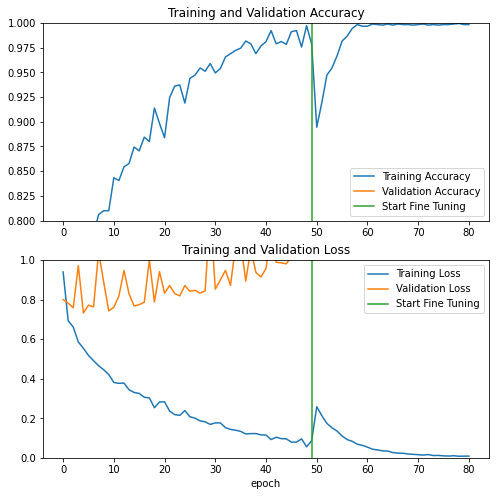

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

2. (3) fine tuning 후 모델 성능 확인 ( test data로 evaluate 진행 )

In [ ]:
test_steps = 20
fine_tuned_loss, fine_tuned_acc = model.evaluate(test_generator, steps=test_steps)
print('fine tuning 후 loss: {0:.4f}\nfine tuning 후 accuracy: {1:.4f}'.format(fine_tuned_loss, fine_tuned_acc))

20/20 [==============================] - 1s 14ms/step - loss: 1.2769 - accuracy: 0.6627
fine tuning 후 loss: 1.2769
fine tuning 후 accuracy: 0.6627


3. 결론

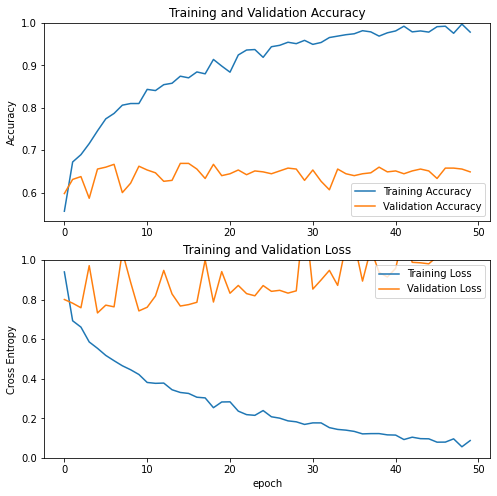 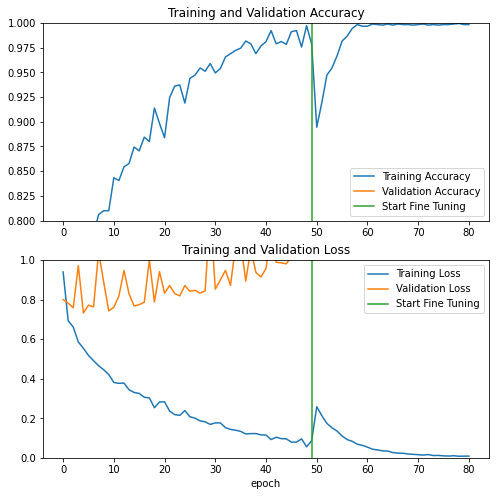

data augmentation을 적용하지 않았을 때 pre-trained MobileNet의 accuracy는 약 0.68이 나왔으며, fine tuning을 적용하면 overfitting으로 인해 acuuracy 약 0.66으로 더 악화되었다

* data augmentation
* weights = None ( 모델 가중치 random 설정 )
    
으로 다시 진행한다

# Pre-trained MobileNet ( augmentation O )

1. conv layer 고정 모델

In [ ]:
from keras.applications.mobilenet import MobileNet
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import RMSprop

base_model = MobileNet(include_top=False, 
                       input_shape=train_generator.image_shape,
                       weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


base_learning_rate = 0.0001
model.compile(optimizer=RMSprop(lr=base_learning_rate), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

In [ ]:
validation_steps = 20
loss0, accuracy0 = model.evaluate(validation_generator, steps=validation_steps)
print('initial loss: {0:.4f}\ninitial accuracy: {1:.4f}'.format(loss0, accuracy0))

20/20 [==============================] - 2s 33ms/step - loss: 1.0893 - accuracy: 0.4729
initial loss: 1.0929
initial accuracy: 0.4689


In [ ]:
initial_epochs = 50
history = model.fit(train_generator_aug, 
                    validation_data=validation_generator, 
                    epochs=initial_epochs)

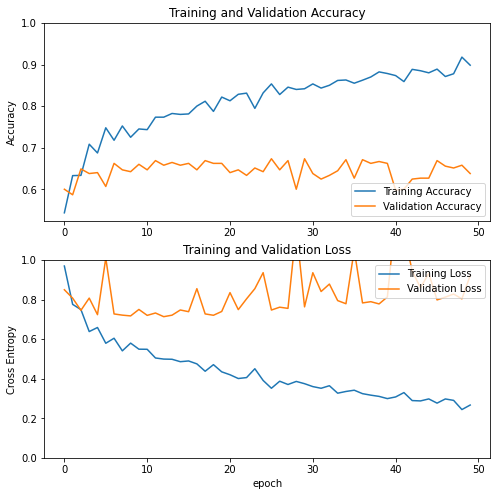

In [ ]:
# 학습 시각화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
test_steps = 20
pre_trained_loss, pre_trained_acc = model.evaluate(test_generator, steps=test_steps)
print('학습 후 loss: {0:.4f}\n학습 후 accuracy: {1:.4f}'.format(pre_trained_loss, pre_trained_acc))

20/20 [==============================] - 1s 14ms/step - loss: 0.7560 - accuracy: 0.7028
학습 후 loss: 0.7560
학습 후 accuracy: 0.7028


data augmentation 이후 accuracy가 0.68에서 0.70으로 향상되었지만 loss도 0.69에서 0.75로 증가하였다

2. fine tuning 적용 모델

In [ ]:
# base model의 모든 층 고정 해제
base_model.trainable = True

# base model의 층 개수 확인
print('Number of layers in the base model:', len(base_model.layers))

# 'fine_tune_at' 이전의 층 모두 고정
fine_tune_at = 70
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model: 86


In [ ]:
# 더 낮은 학습 비율로 기존의 model compile 진행

model.compile(optimizer=RMSprop(lr=base_learning_rate/10), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

In [ ]:
fine_tune_epochs = 30
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_generator_aug,
                         validation_data=validation_generator,
                         initial_epoch=history.epoch[-1],
                         epochs=total_epochs)

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

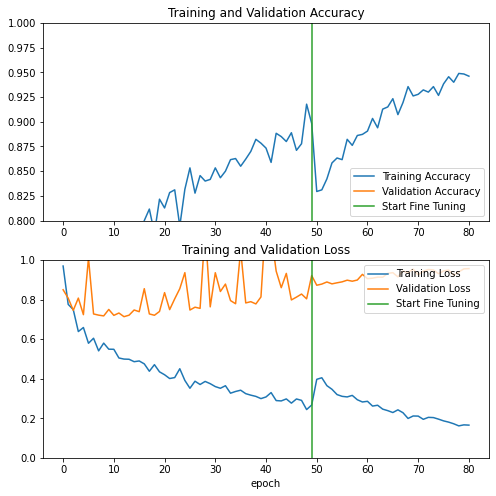

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
test_steps = 20
fine_tuned_loss, fine_tuned_acc = model.evaluate(test_generator, steps=test_steps)
print('fine tuning 후 loss: {0:.4f}\nfine tuning 후 accuracy: {1:.4f}'.format(fine_tuned_loss, fine_tuned_acc))

20/20 [==============================] - 1s 14ms/step - loss: 0.8240 - accuracy: 0.7269
fine tuning 후 loss: 0.8240
fine tuning 후 accuracy: 0.7269


3. 결론

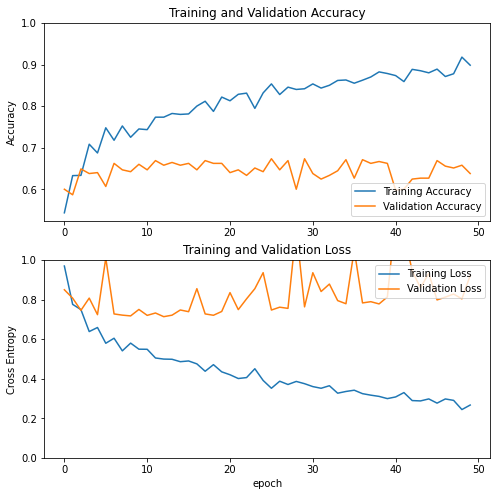 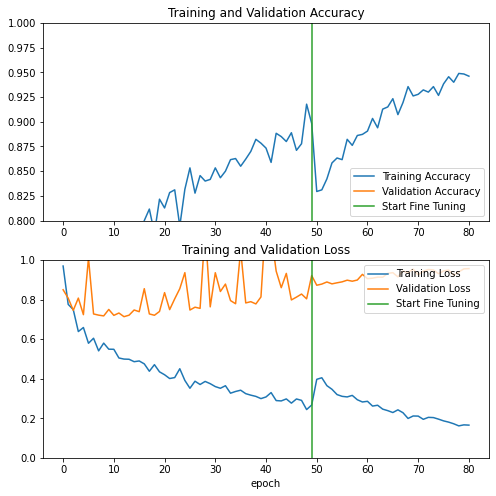

data augmentation 적용 후 accuracy가 약 0.70으로 향상되었으나 loss 또한 급격히 증가하였고, fine tuning 이후 accuracy가 0.72로 향상하였으나 loss가 급격히 증가하여 성능이 악화되었다.

# Not pre-trained MobileNet

MobileNet의 구조를 이용하되 가중치를 random으로 지정하고, 모든 레이어에서 가중치 업데이트가 이루어지도록 레이어 고정을 해제한다

: 학습이 제대로 진행되지 않는다 -> Pre-trained 모델을 사용하는 것이 더 좋다

In [ ]:
from keras.applications.mobilenet import MobileNet
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import RMSprop

base_model = MobileNet(include_top=False, 
                       input_shape=train_generator.image_shape,
                       weights=None)

#for layer in base_model.layers:
#    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


base_learning_rate = 0.0001
model.compile(optimizer=RMSprop(lr=base_learning_rate), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 160, 160, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 80, 80, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 80, 80, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 80, 80, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 80, 80, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 80, 80, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 80, 80, 32)        0   

In [ ]:
validation_steps = 20
loss0, accuracy0 = model.evaluate(validation_generator, steps=validation_steps)
print('initial loss: {0:.4f}\ninitial accuracy: {1:.4f}'.format(loss0, accuracy0))

20/20 [==============================] - 2s 34ms/step - loss: 1.0986 - accuracy: 0.3920
initial loss: 1.0986
initial accuracy: 0.3933


In [ ]:
initial_epochs = 50
history = model.fit(train_generator, 
                    validation_data=validation_generator, 
                    epochs=initial_epochs)

Epoch 1/50
18/18 [==============================] - 10s 347ms/step - loss: 0.8932 - accuracy: 0.4961 - val_loss: 1.0698 - val_accuracy: 0.3933
Epoch 2/50
18/18 [==============================] - 6s 338ms/step - loss: 0.8248 - accuracy: 0.5511 - val_loss: 1.0373 - val_accuracy: 0.5644
Epoch 3/50
18/18 [==============================] - 6s 336ms/step - loss: 0.8122 - accuracy: 0.5656 - val_loss: 1.0308 - val_accuracy: 0.3933
Epoch 4/50
18/18 [==============================] - 6s 341ms/step - loss: 0.7707 - accuracy: 0.6217 - val_loss: 0.9842 - val_accuracy: 0.5644
Epoch 5/50
18/18 [==============================] - 6s 345ms/step - loss: 0.7252 - accuracy: 0.6500 - val_loss: 0.9830 - val_accuracy: 0.3933
Epoch 6/50
18/18 [==============================] - 6s 341ms/step - loss: 0.6250 - accuracy: 0.7383 - val_loss: 0.9511 - val_accuracy: 0.3933
Epoch 7/50
18/18 [==============================] - 7s 358ms/step - loss: 0.5309 - accuracy: 0.7883 - val_loss: 0.9381 - val_accuracy: 0.3933
Epoch

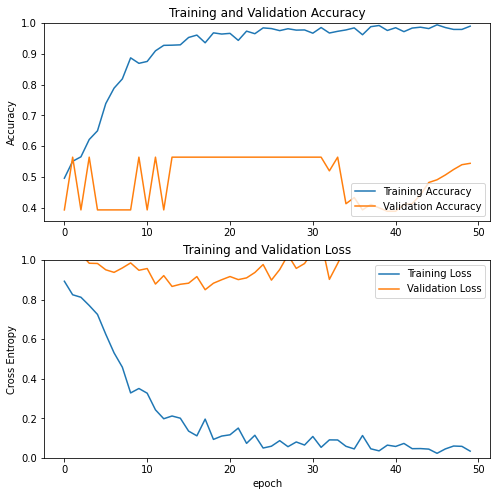

In [ ]:
# 학습 시각화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
test_steps = 20
fine_tuned_loss, fine_tuned_acc = model.evaluate(test_generator, steps=test_steps)
print('fine tuning 후 loss: {0:.4f}\nfine tuning 후 accuracy: {1:.4f}'.format(fine_tuned_loss, fine_tuned_acc))

20/20 [==============================] - 1s 13ms/step - loss: 2.7113 - accuracy: 0.5141
fine tuning 후 loss: 2.7113
fine tuning 후 accuracy: 0.5141


# Pre-trained model 탐색

* MobileNet

In [ ]:
from keras.applications import MobileNet
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from keras.optimizers import RMSprop, Adam

base_model = MobileNet(include_top=False, 
                            input_shape=train_generator.image_shape,
                            weights='imagenet')

print(len(base_model.trainable_variables))


for layer in base_model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

base_learning_rate = 0.001
model.compile(optimizer=Adam(learning_rate=base_learning_rate/10), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

print(len(model.trainable_variables))

81
Model: "model_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 160, 160, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 80, 80, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 80, 80, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 80, 80, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 80, 80, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 80, 80, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 80, 80, 32)        

In [ ]:
import math

loss0, accuracy0 = model.evaluate(validation_generator, steps=math.ceil(validation_generator.n/validation_generator.batch_size))
print('initial loss: {0:.4f}\ninitial accuracy: {1:.4f}'.format(loss0, accuracy0))

5/5 [==============================] - 2s 153ms/step - loss: 1.3065 - accuracy: 0.3763
initial loss: 1.2820
initial accuracy: 0.3933


In [ ]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   patience=10)

In [ ]:
initial_epochs = 100
history = model.fit(train_generator_aug, 
                    validation_data=validation_generator, 
                    epochs=initial_epochs,
                    steps_per_epoch=math.ceil(train_generator_aug.n/train_generator_aug.batch_size),
                    validation_steps=math.ceil(validation_generator.n/validation_generator.batch_size),
                    callbacks=[es])

Epoch 1/100
18/18 [==============================] - 14s 691ms/step - loss: 1.9902 - accuracy: 0.3556 - val_loss: 1.2212 - val_accuracy: 0.4200
Epoch 2/100
18/18 [==============================] - 12s 685ms/step - loss: 1.8501 - accuracy: 0.3589 - val_loss: 1.1675 - val_accuracy: 0.4467
Epoch 3/100
18/18 [==============================] - 13s 697ms/step - loss: 1.8491 - accuracy: 0.3750 - val_loss: 1.1286 - val_accuracy: 0.4600
Epoch 4/100
18/18 [==============================] - 12s 676ms/step - loss: 1.7434 - accuracy: 0.3850 - val_loss: 1.0944 - val_accuracy: 0.4756
Epoch 5/100
18/18 [==============================] - 12s 674ms/step - loss: 1.6844 - accuracy: 0.3889 - val_loss: 1.0620 - val_accuracy: 0.4933
Epoch 6/100
18/18 [==============================] - 12s 682ms/step - loss: 1.6148 - accuracy: 0.4072 - val_loss: 1.0343 - val_accuracy: 0.5156
Epoch 7/100
18/18 [==============================] - 12s 677ms/step - loss: 1.5590 - accuracy: 0.4350 - val_loss: 1.0126 - val_accuracy:

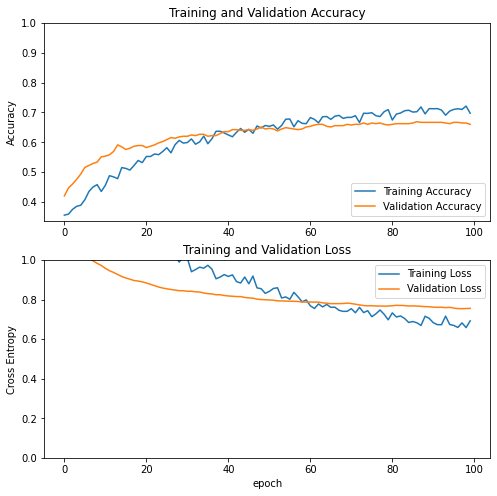

In [ ]:
visualize_train(history)

In [ ]:
import matplotlib.pyplot as plt

def visualize_train(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [ ]:
pre_trained_loss, pre_trained_acc = model.evaluate(test_generator, steps=math.ceil(test_generator.n/test_generator.batch_size))
print('학습 후 loss: {0:.4f}\n학습 후 accuracy: {1:.4f}'.format(pre_trained_loss, pre_trained_acc))

3/3 [==============================] - 1s 134ms/step - loss: 0.7232 - accuracy: 0.7028
학습 후 loss: 0.7232
학습 후 accuracy: 0.7028


In [ ]:
# base model의 모든 층 고정 해제
base_model.trainable = True

# base model의 층 개수 확인
print('Number of layers in the base model:', len(base_model.layers))

# 'fine_tune_at' 이전의 층 모두 고정
fine_tune_at = 70
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model: 86


In [ ]:
# 더 낮은 학습 비율로 기존의 model compile 진행

model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "model_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 160, 160, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 80, 80, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 80, 80, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 80, 80, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 80, 80, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 80, 80, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 80, 80, 32)        0  

In [ ]:
fine_tune_epochs = 30
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_generator,
                         validation_data=validation_generator,
                         initial_epoch=history.epoch[-1],
                         epochs=total_epochs,
                         callbacks=[es])

Epoch 100/130
18/18 [==============================] - 6s 261ms/step - loss: 0.2332 - accuracy: 0.9168 - val_loss: 0.9408 - val_accuracy: 0.6533
Epoch 101/130
18/18 [==============================] - 4s 237ms/step - loss: 0.1725 - accuracy: 0.9514 - val_loss: 0.9907 - val_accuracy: 0.6400
Epoch 102/130
18/18 [==============================] - 4s 240ms/step - loss: 0.1456 - accuracy: 0.9661 - val_loss: 0.9189 - val_accuracy: 0.6778
Epoch 103/130
18/18 [==============================] - 4s 243ms/step - loss: 0.1179 - accuracy: 0.9779 - val_loss: 0.9803 - val_accuracy: 0.6667
Epoch 104/130
18/18 [==============================] - 4s 244ms/step - loss: 0.1024 - accuracy: 0.9810 - val_loss: 1.0884 - val_accuracy: 0.6400
Epoch 105/130
18/18 [==============================] - 4s 250ms/step - loss: 0.1009 - accuracy: 0.9697 - val_loss: 1.0573 - val_accuracy: 0.6556
Epoch 106/130
18/18 [==============================] - 5s 257ms/step - loss: 0.0600 - accuracy: 0.9911 - val_loss: 1.0521 - val_ac

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

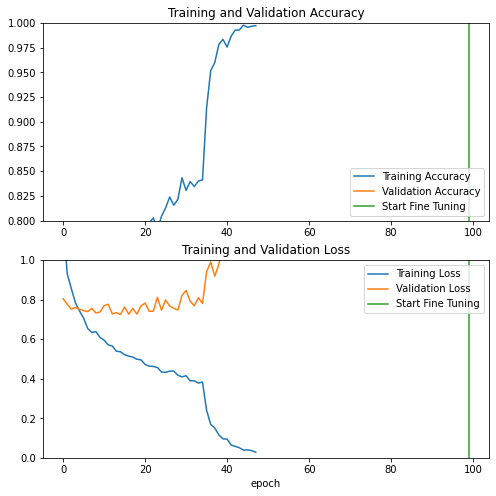

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()